# Node classification with Cluster-GCN

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/cluster-gcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/cluster-gcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This notebook demonstrates how to use `StellarGraph`'s implementation of *Cluster-GCN*, [1], for node classification on a homogeneous graph.

*Cluster-GCN* is a training method for scalable training of deeper Graph Neural Networks using Stochastic Gradient Descent (SGD). It is implemented as the `ClusterNodeGenerator` class ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.ClusterNodeGenerator)) in StellarGraph, which can be used with [GCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN) [2] (demonstrated here), [GAT](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GAT) and [APPNP](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.APPNP) models.

As a first step, *Cluster-GCN* splits a given graph into `k` non-overlapping subgraphs, i.e., no two subgraphs share a node. In [1], it is suggested that for best classification performance, the *METIS* graph clustering algorithm, [3], should be utilised; *METIS* groups together nodes that form a well connected neighborhood with few connections to other subgraphs. The default clustering algorithm `StellarGraph` uses is the random assignment of nodes to clusters. The user is free to use any suitable clustering algorithm to determine the clusters before training the *Cluster-GCN* model. 

This notebook demonstrates how to use either random clustering or METIS. For the latter, it is necessary that 3rd party software has correctly been installed; later, we provide links to websites that host the software and provide detailed installation instructions. 

During model training, each subgraph or combination of subgraphs is treated as a mini-batch for estimating the parameters of a *GCN* model. A pass over all subgraphs is considered a training epoch.

*Cluster-GCN* further extends *GCN* from the transductive to the inductive setting but this is not demonstrated in this notebook.

This notebook demonstrates *Cluster-GCN* for node classification using 2 citation network datasets, `Cora` and `PubMed-Diabetes`.

**References**

[1] Cluster-GCN: An Efficient Algorithm for Training Deep and Large Graph Convolutional Networks. W. Chiang, X. Liu, S. Si, Y. Li, S. Bengio, and C. Hsiej, KDD, 2019, arXiv:1905.07953 ([download link](https://arxiv.org/abs/1905.07953))

[2] Semi-Supervised Classification with Graph Convolutional Networks. T. Kipf, M. Welling. ICLR 2017. arXiv:1609.02907 ([download link](https://arxiv.org/abs/1609.02907))

[3] METIS: Serial Graph Partitioning and Fill-reducing Matrix Ordering. ([download link](http://glaros.dtc.umn.edu/gkhome/views/metis))

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.0

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

<div class="alert alert-block alert-danger">This notebook is designed for an older StellarGraph version 1.2.0 and may not function correctly with the newer installed version 1.2.1. Please see: <a href="https://github.com/stellargraph/stellargraph/issues/1172">https://github.com/stellargraph/stellargraph/issues/1172</a>.</div>

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This notebook is designed for an older StellarGraph version 1.2.0 and may not function correctly with the newer installed version 1.2.1. Please see: <https://github.com/stellargraph/stellargraph/issues/1172>.
  """


In [3]:
import networkx as nx
import pandas as pd
import itertools
import json
import os
from collections import Counter 

os.environ["METIS_DLL"] = '/home/AzureUser/.local/lib/libmetis.so'

import metis
import numpy as np
import pickle

from networkx.readwrite import json_graph

from sklearn.preprocessing import StandardScaler

import stellargraph as sg
from stellargraph.mapper import ClusterNodeGenerator
from stellargraph.layer import GCN
from stellargraph import globalvar
from stellargraph import StellarGraph

from tensorflow.keras import backend as K

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the dataset

This notebook demonstrates node classification using the *Cluster-GCN* algorithm using `Amazon Electronics product data`.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [8]:
data_dir = '/recsys_data/RecSys/SASRec-tf2/data'
dataset = 'ae_v2'

edges = pd.read_csv(
    os.path.join(data_dir, dataset+'_edges.txt'),
    sep="\t",  # tab-separated
    header=None,  # no heading row
    names=["target", "source", "type"],  # set our own names for the columns
)[["target", "source"]]
edges

,target,source
0,0,62487
1,0,78783
2,0,70929
3,1,72957
4,1,2
...,...,...
1679002,85926,75839
1679003,85926,48089
1679004,85927,77159
1679005,85927,77159


In [5]:
feature_names = [f"d{i}" for i in range(50)]

raw_content = pd.read_csv(
    os.path.join(data_dir, dataset+'_nodes.txt'),
    sep="\t",  # tab-separated
    header=None,  # no heading row
    names=["id", *feature_names, "subject"],  # set our own names for the columns
)
raw_content

,id,d0,d1,d2,d3,d4,d5,d6,d7,d8,...,d41,d42,d43,d44,d45,d46,d47,d48,d49,subject
0,0,0.311127,0.189953,0.311141,0.018312,0.157203,0.151874,-0.414873,-0.318316,0.066389,...,0.074821,0.083126,0.120595,-0.095712,0.075398,0.073666,-0.092479,0.002540,-0.092554,GPS & Navigation
1,1,0.192150,0.260551,0.378347,0.206677,0.141021,0.094778,-0.280556,-0.553474,0.294945,...,0.250556,-0.330763,0.192404,-0.283008,0.095680,0.210608,-0.151987,-0.044246,0.122673,Computers & Accessories
2,2,0.193242,0.172278,0.238875,0.135982,0.271211,0.125392,-0.318736,-0.465599,0.104177,...,0.061728,-0.192212,0.194312,-0.137361,0.180154,0.039050,-0.146513,0.012492,0.238627,eBook Readers & Accessories
3,3,0.126144,0.261877,0.172442,-0.090060,0.405573,0.014652,-0.341531,-0.497896,0.248942,...,0.130474,-0.128374,0.288147,-0.063115,0.156623,0.183189,-0.234431,0.029924,-0.017226,eBook Readers & Accessories
4,4,0.181886,0.228990,0.203993,0.142382,0.163389,-0.036058,-0.504200,-0.494060,0.087317,...,-0.045687,0.002570,0.039246,-0.113593,0.190292,0.123915,-0.204091,0.009451,-0.010934,GPS & Navigation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85925,85925,0.203777,0.250222,0.459110,0.223148,0.176504,0.141176,-0.222852,-0.392803,-0.030289,...,0.016214,-0.123502,0.153429,-0.216055,0.204646,0.241823,-0.101421,0.218140,-0.000417,Computers & Accessories
85926,85926,0.089006,0.057531,0.241886,0.157024,0.067459,0.118381,-0.236419,-0.395329,-0.102482,...,0.095753,-0.217950,0.081654,-0.097427,0.190722,0.204508,-0.059799,-0.102938,0.004785,Home Audio
85927,85927,-0.135549,0.106206,1.094022,0.392229,-0.053735,-0.059150,0.243706,-0.657034,-0.244783,...,0.018100,-0.176282,-0.131259,-0.102871,0.026566,0.143284,0.004262,-0.447138,-0.041858,Television & Video
85928,85928,0.055946,0.312002,0.304513,0.098743,0.078615,0.328413,-0.100217,-0.343828,-0.059103,...,0.181784,-0.105346,0.042111,-0.161093,0.146541,0.170069,-0.030938,-0.106007,0.034217,Car & Vehicle Electronics


In [9]:
content_str_subject = raw_content.set_index("id")
content_no_subject = content_str_subject.drop(columns="subject")
G = StellarGraph({"items": content_no_subject}, {"related": edges})
labels = content_str_subject["subject"].copy()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 85930, Edges: 1679007

 Node types:
  items: [85930]
    Features: float32 vector, length 50
    Edge types: items-related->items

 Edge types:
    items-related->items: [1679007]
        Weights: all 1 (default)
        Features: none


In [10]:
labels.value_counts()

Computers & Accessories        37416
Camera & Photo                 15404
Accessories & Supplies         11932
Portable Audio & Video          6996
Television & Video              4029
Car & Vehicle Electronics       3819
Home Audio                      2363
GPS & Navigation                1566
eBook Readers & Accessories      892
Security & Surveillance          570
Accessories                      457
Cases                            243
Electronics Warranties           193
Service & Replacement Plans       21
Cell Phones                       10
Tools & Equipment                  5
Luggage & Travel Gear              4
Connected Devices                  4
Car Care                           2
Interior Accessories               2
Hair Care                          1
C                                  1
Name: subject, dtype: int64

In [11]:
remove_classes = list(labels.value_counts()[labels.value_counts()<100].index)
labels[labels.isin(remove_classes)] = 'others'

In [12]:
Counter(labels)

Counter({'GPS & Navigation': 1566,
         'Computers & Accessories': 37416,
         'eBook Readers & Accessories': 892,
         'Accessories & Supplies': 11932,
         'Camera & Photo': 15404,
         'Portable Audio & Video': 6996,
         'Car & Vehicle Electronics': 3819,
         'Home Audio': 2363,
         'Television & Video': 4029,
         'Security & Surveillance': 570,
         'others': 50,
         'Accessories': 457,
         'Cases': 243,
         'Electronics Warranties': 193})

In [13]:
set(labels)

{'Accessories',
 'Accessories & Supplies',
 'Camera & Photo',
 'Car & Vehicle Electronics',
 'Cases',
 'Computers & Accessories',
 'Electronics Warranties',
 'GPS & Navigation',
 'Home Audio',
 'Portable Audio & Video',
 'Security & Surveillance',
 'Television & Video',
 'eBook Readers & Accessories',
 'others'}

### Splitting the data

We aim to train a graph-ML model that will predict the **subject** or **label** (depending on the dataset) attribute on the nodes.

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

The number of labeled nodes we use for training depends on the dataset. We use 140 labeled nodes for `Cora` and 60 for `Pubmed` training. The validation and test sets have the same sizes for both datasets. We use 500 nodes for validation and the rest for testing.

In [14]:
train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=0.8, test_size=None, stratify=labels
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=0.5, test_size=None, stratify=test_labels
)

In [15]:
len(train_labels), len(val_labels), len(test_labels)

(68744, 8593, 8593)

Note using stratified sampling gives the following counts:

In [16]:
Counter(train_labels)

Counter({'Computers & Accessories': 29933,
         'Camera & Photo': 12323,
         'Car & Vehicle Electronics': 3055,
         'Television & Video': 3223,
         'Accessories': 366,
         'eBook Readers & Accessories': 714,
         'Accessories & Supplies': 9546,
         'Portable Audio & Video': 5597,
         'Home Audio': 1890,
         'GPS & Navigation': 1253,
         'others': 40,
         'Electronics Warranties': 154,
         'Security & Surveillance': 456,
         'Cases': 194})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [17]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

Next, we prepare a Pandas DataFrame holding the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. `Cora` contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero. `Pubmed` has similar feature vectors associated with each node but the values are [tf-idf.](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

## Train using cluster GCN

### Graph Clustering 

*Cluster-GCN* requires that a graph is clustered into `k` non-overlapping subgraphs. These subgraphs are used as batches to train a *GCN* model. 

Any graph clustering method can be used, including random clustering that is the default clustering method in `StellarGraph`. 

However, the choice of clustering algorithm can have a large impact on performance. In the *Cluster-GCN* paper, [1], it is suggested that the *METIS* algorithm is used as it produces subgraphs that are well connected with few intra-graph edges. 

This demo uses random clustering by default. 

#### METIS

In order to use *METIS*, you must download and install the official implementation from [here](http://glaros.dtc.umn.edu/gkhome/views/metis). Also, you must install the Python `metis` library by following the instructions [here.](https://metis.readthedocs.io/en/latest/)

In [18]:
number_of_clusters = 10  # the number of clusters/subgraphs
clusters_per_batch = 2  # combine two cluster per batch
random_clusters = False  # Set to False if you want to use METIS for clustering

In [19]:
node_ids = np.array(G.nodes())

In [20]:
if random_clusters:
    # We don't have to specify the cluster because the CluserNodeGenerator will take
    # care of the random clustering for us.
    clusters = number_of_clusters
else:
    # We are going to use the METIS clustering algorith,
    print("Graph clustering using the METIS algorithm.")

    lil_adj = G.to_adjacency_matrix().tolil()
    adjlist = [tuple(neighbours) for neighbours in lil_adj.rows]

    edgecuts, parts = metis.part_graph(adjlist, number_of_clusters)
    parts = np.array(parts)
    clusters = []
    cluster_ids = np.unique(parts)
    for cluster_id in cluster_ids:
        mask = np.where(parts == cluster_id)
        clusters.append(node_ids[mask])

Graph clustering using the METIS algorithm.


Next we create the `ClusterNodeGenerator` object ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.ClusterNodeGenerator)) that will give us access to a generator suitable for model training, evaluation, and prediction via the Keras API. 

We specify the number of clusters and the number of clusters to combine per batch, **q**.

In [21]:
generator = ClusterNodeGenerator(G, clusters=clusters, q=clusters_per_batch, lam=0.1)

Number of clusters 10
0 cluster has size 8758
1 cluster has size 8541
2 cluster has size 8356
3 cluster has size 8355
4 cluster has size 8683
5 cluster has size 8342
6 cluster has size 8851
7 cluster has size 8851
8 cluster has size 8851
9 cluster has size 8342


Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 32-dimensional hidden node features at each layer.
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer. 

We create the `GCN` model ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN)) for training with *Cluster-GCN* as follows:

In [22]:
cluster_gcn = GCN(
    layer_sizes=[64, 64], activations=["relu", "relu"], generator=generator, dropout=0.5
)

To create a Keras model we now expose the input and output tensors of the *Cluster-GCN* model for node prediction, via the `GCN.in_out_tensors` method ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN.in_out_tensors)):

In [23]:
x_inp, x_out = cluster_gcn.in_out_tensors()

In [24]:
x_inp

[<tf.Tensor 'input_1:0' shape=(1, None, 50) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(1, None) dtype=int32>,
 <tf.Tensor 'input_3:0' shape=(1, None, None) dtype=float32>]

In [25]:
x_out

<tf.Tensor 'gather_indices/GatherV2:0' shape=(1, None, 64) dtype=float32>

We are also going to add a final layer dense layer with softmax output activation. This layers performs classification so we set the number of units to equal the number of classes.

In [26]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [27]:
predictions

<tf.Tensor 'dense/truediv:0' shape=(1, None, 14) dtype=float32>

Finally, we build the TensorFlow model and compile it specifying the loss function, optimiser, and metrics to monitor.

In [28]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

### Train the model

We are now ready to train the `GCN` model using *Cluster-GCN*, keeping track of its loss and accuracy on the training set, and its generalisation performance on a validation set.

We need two generators, one for training and one for validation data. We can create such generators by calling the `flow` method of the `ClusterNodeGenerator` object we created earlier and specifying the node IDs and corresponding ground truth target values for each of the two datasets. 

In [29]:
train_gen = generator.flow(train_labels.index, train_targets, name="train")
val_gen = generator.flow(val_labels.index, val_targets, name="val")

Finally, we are ready to train our `GCN` model by calling the `fit` method of our TensorFlow Keras model.

In [30]:
history = model.fit(
    train_gen, validation_data=val_gen, epochs=100, verbose=1, shuffle=False
)

Epoch 1/100
5/5 [==============================] - 16s 3s/step - loss: 2.3831 - acc: 0.3333 - val_loss: 1.8613 - val_acc: 0.4355
Epoch 2/100
5/5 [==============================] - 15s 3s/step - loss: 1.9340 - acc: 0.4349 - val_loss: 1.6927 - val_acc: 0.4358
Epoch 3/100
5/5 [==============================] - 15s 3s/step - loss: 1.7468 - acc: 0.4338 - val_loss: 1.6152 - val_acc: 0.4358
Epoch 4/100
5/5 [==============================] - 15s 3s/step - loss: 1.6959 - acc: 0.4356 - val_loss: 1.5708 - val_acc: 0.4501
Epoch 5/100
5/5 [==============================] - 15s 3s/step - loss: 1.6176 - acc: 0.4598 - val_loss: 1.5094 - val_acc: 0.4838
Epoch 6/100
5/5 [==============================] - 15s 3s/step - loss: 1.5647 - acc: 0.4682 - val_loss: 1.4044 - val_acc: 0.5893
Epoch 7/100
5/5 [==============================] - 15s 3s/step - loss: 1.4848 - acc: 0.5485 - val_loss: 1.3454 - val_acc: 0.5956
Epoch 8/100
5/5 [==============================] - 15s 3s/step - loss: 1.4627 - acc: 0.5395 - val

5/5 [==============================] - 15s 3s/step - loss: 0.8437 - acc: 0.7533 - val_loss: 0.6632 - val_acc: 0.8037
Epoch 65/100
5/5 [==============================] - 15s 3s/step - loss: 0.8273 - acc: 0.7524 - val_loss: 0.6654 - val_acc: 0.8089
Epoch 66/100
5/5 [==============================] - 15s 3s/step - loss: 0.8414 - acc: 0.7563 - val_loss: 0.6460 - val_acc: 0.8115
Epoch 67/100
5/5 [==============================] - 15s 3s/step - loss: 0.8304 - acc: 0.7587 - val_loss: 0.6470 - val_acc: 0.8175
Epoch 68/100
5/5 [==============================] - 15s 3s/step - loss: 0.8236 - acc: 0.7569 - val_loss: 0.6434 - val_acc: 0.8162
Epoch 69/100
5/5 [==============================] - 15s 3s/step - loss: 0.8242 - acc: 0.7565 - val_loss: 0.6441 - val_acc: 0.8145
Epoch 70/100
5/5 [==============================] - 15s 3s/step - loss: 0.8370 - acc: 0.7530 - val_loss: 0.6339 - val_acc: 0.8161
Epoch 71/100
5/5 [==============================] - 15s 3s/step - loss: 0.8114 - acc: 0.7644 - val_loss

Plot the training history:

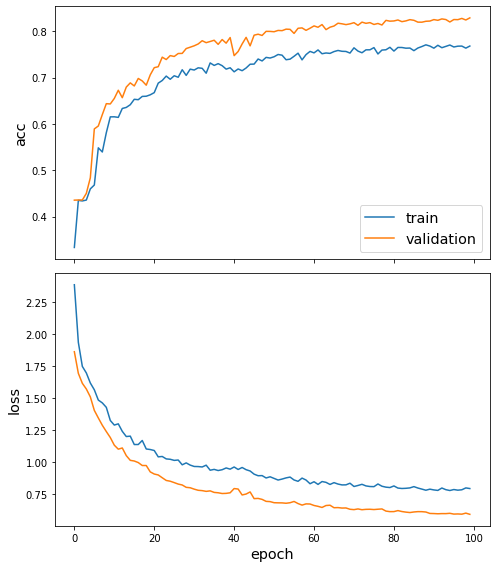

In [31]:
sg.utils.plot_history(history)

Evaluate the best model on the test set.

Note that *Cluster-GCN* performance can be very poor if using random graph clustering. Using *METIS* instead of random graph clustering produces considerably better results.

In [32]:
test_gen = generator.flow(test_labels.index, test_targets)

In [33]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 6s 1s/step - loss: 0.6006 - acc: 0.8210

Test Set Metrics:
	loss: 0.6006
	acc: 0.8210


### Making predictions with the model

For predictions to work correctly, we need to remove the extra batch dimensions necessary for the implementation of *Cluster-GCN* to work. We can easily achieve this by adding a layer after the dense predictions layer to remove this extra dimension.

In [34]:
predictions_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(predictions)

In [35]:
# Notice that we have removed the first dimension
predictions, predictions_flat

(<tf.Tensor 'dense/truediv:0' shape=(1, None, 14) dtype=float32>,
 <tf.Tensor 'lambda_1/Squeeze:0' shape=(None, 14) dtype=float32>)

Now let's get the predictions for all nodes.

We need to create a new model using the same as before input Tensor and our new **predictions_flat** Tensor as the output. We are going to re-use the trained model weights.

In [36]:
model_predict = Model(inputs=x_inp, outputs=predictions_flat)

In [37]:
all_nodes = list(G.nodes())
all_gen = generator.flow(all_nodes, name="all_gen")
all_predictions = model_predict.predict(all_gen)

In [38]:
all_predictions.shape

(85930, 14)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specification to turn these values back to the original categories.

In [39]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few predictions after training the model:

In [40]:
len(all_gen.node_order)

85930

In [41]:
results = pd.Series(node_predictions, index=all_gen.node_order)
df = pd.DataFrame({"Predicted": results, "True": labels})
df.head(10)

,Predicted,True
0,GPS & Navigation,GPS & Navigation
1,Computers & Accessories,Computers & Accessories
2,Computers & Accessories,eBook Readers & Accessories
3,Computers & Accessories,eBook Readers & Accessories
4,Computers & Accessories,GPS & Navigation
5,Accessories & Supplies,Accessories & Supplies
6,Computers & Accessories,eBook Readers & Accessories
7,Computers & Accessories,eBook Readers & Accessories
8,Computers & Accessories,eBook Readers & Accessories
9,eBook Readers & Accessories,eBook Readers & Accessories


## Node embeddings

Evaluate node embeddings as activations of the output of the last graph convolution layer in the `GCN` layer stack and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

To calculate the node embeddings rather than the class predictions, we create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings `x_out` rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

Note that the embeddings from the `GCN` model have a batch dimension of 1 so we `squeeze` this to get a matrix of $N_{nodes} \times N_{emb}$.

In [42]:
x_out_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(x_out)
embedding_model = Model(inputs=x_inp, outputs=x_out_flat)

In [43]:
emb = embedding_model.predict(all_gen, verbose=1)
emb.shape

5/5 [==============================] - 7s 1s/step


(85930, 64)

In [45]:
len(set(all_gen.node_order))

85930

In [47]:
min(all_gen.node_order), max(all_gen.node_order)

(0, 85929)

In [49]:
np.linalg.norm(emb, axis=-1)

array([6.078968 , 5.655482 , 5.628472 , ..., 5.7752995, 6.17762  ,
       6.1556067], dtype=float32)

In [50]:
# pd.Series(range(85930)).reindex(index=all_gen.node_order)
emb_ordered = np.zeros(emb.shape)
for ii, node in enumerate(all_gen.node_order):
    emb_ordered[node,:] = emb[ii,:]

In [51]:
import pickle

with open(f"../data/{dataset}_item_embeddings.pkl", 'wb') as handle:
    pickle.dump(emb_ordered, handle, protocol=pickle.HIGHEST_PROTOCOL)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their true subject label

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

**Prediction Node Order**

The predictions are not returned in the same order as the input nodes given. The generator object internally maintains the order of predictions. These are stored in the object's member variable `node_order`. We use `node_order` to re-index the `node_data` DataFrame such that the prediction order in `y` corresponds to that of node embeddings in `X`.

In [128]:
X = emb
y = np.argmax(
    target_encoding.transform(labels.reindex(index=all_gen.node_order)), axis=1,
)

In [129]:
if X.shape[1] > 2:
    transform = TSNE  # or use PCA for speed

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=all_gen.node_order)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

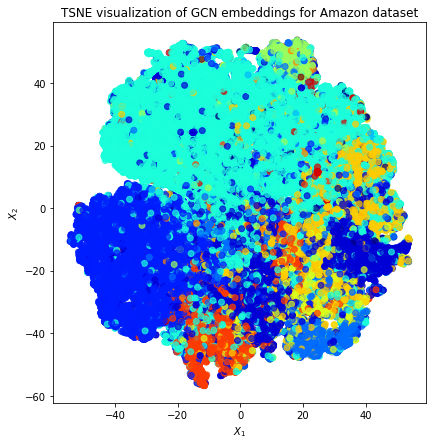

In [130]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GCN embeddings for Amazon dataset".format(transform.__name__)
)
plt.show()

### Embeddings of the Test Data

In [44]:
test_emb = embedding_model.predict(test_gen, verbose=1)
test_emb.shape

5/5 [==============================] - 17s 3s/step


(8593, 64)

In [45]:
X = test_emb
y = np.argmax(
    target_encoding.transform(test_labels.reindex(index=test_gen.node_order)), axis=1,
)

In [46]:
transform = TSNE  # or use PCA for speed

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=test_gen.node_order)
emb_transformed["label"] = y

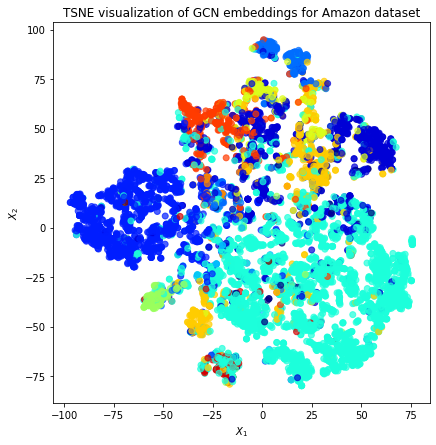

In [47]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GCN embeddings for Amazon dataset".format(transform.__name__)
)
plt.show()

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/cluster-gcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/cluster-gcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>